In [8]:

# -*- coding: utf-8 -*-
"""
Swin Transformer + Tabular Multimodal Energy Prediction
FIXED VERSION - Corrected Phase 1 Training Strategy
NO DATA LEAKAGE VERSION - Clean features only
"""

import os
import pandas as pd
import numpy as np
import rasterio
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import RandomRotation, RandomHorizontalFlip
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
import cv2
import warnings
import matplotlib.pyplot as plt

try:
    import timm
    print("✅ timm library loaded successfully!")
except ImportError:
    print("❌ timm not found. Please install: pip install timm")
    raise

warnings.filterwarnings('ignore')

print("✅ Libraries loaded successfully!")
print(f"🔥 PyTorch version: {torch.__version__}")
print(f"🎮 CUDA available: {torch.cuda.is_available()}")
print(f"📦 timm version: {timm.__version__}")

✅ timm library loaded successfully!
✅ Libraries loaded successfully!
🔥 PyTorch version: 2.9.0+cu126
🎮 CUDA available: True
📦 timm version: 1.0.21


In [9]:
class TabularEncoder(nn.Module):
    """
    Clean tabular encoder - NO DATA LEAKAGE
    Features (6 total):
    - log_population, log_area, log_density
    - month_sin, month_cos, year_normalized
    """
    def __init__(self, num_features=6, output_dim=512, dropout=0.3):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        x = x.float()
        x = torch.nan_to_num(x, nan=0.0, posinf=1.0, neginf=-1.0)
        return self.encoder(x)


print("✅ Tabular encoder ready - NO LEAKAGE!")
print("   Features: population, area, density, seasonality, time trend")

✅ Tabular encoder ready - NO LEAKAGE!
   Features: population, area, density, seasonality, time trend


In [10]:
class FusionLayer(nn.Module):
    """Simple concatenation + MLP fusion"""
    def __init__(self, vision_dim=512, tabular_dim=512, output_dim=512, dropout=0.3):
        super().__init__()
        self.fusion = nn.Sequential(
            nn.Linear(vision_dim + tabular_dim, 1024),
            nn.LayerNorm(1024),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024, output_dim),
            nn.LayerNorm(output_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

    def forward(self, vision_feat, tabular_feat):
        combined = torch.cat([vision_feat, tabular_feat], dim=-1)
        return self.fusion(combined)


print("✅ Fusion layer ready!")

✅ Fusion layer ready!


In [11]:
class SwinMultimodalModel(nn.Module):
    """
    Swin + Tabular Multimodal Model
    Architecture:
    1. Swin Transformer (pretrained) → 768-dim
    2. Vision Projection → 512-dim
    3. Tabular Encoder → 512-dim
    4. Fusion (concat + MLP) → 512-dim
    5. Prediction Head → 1
    """
    def __init__(self,
                 swin_variant='swin_tiny_patch4_window7_224',
                 num_tabular_features=6,
                 dropout=0.3,
                 pretrained=True):
        super().__init__()

        print(f"\n🔨 Building Swin Multimodal Model...")
        print(f"   Vision: {swin_variant}")
        print(f"   Tabular features: {num_tabular_features}")
        print(f"   Pretrained: {pretrained}")

        # 1. Swin Transformer
        self.swin = timm.create_model(
            swin_variant,
            pretrained=pretrained,
            num_classes=0,
            global_pool='avg',
            in_chans=1,
            img_size=64
        )

        swin_out_dim = self.swin.num_features
        print(f"   Swin output dim: {swin_out_dim}")

        # 2. Vision projection
        self.vision_proj = nn.Sequential(
            nn.Linear(swin_out_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # 3. Tabular encoder
        self.tabular_encoder = TabularEncoder(
            num_features=num_tabular_features,
            output_dim=512,
            dropout=dropout
        )

        # 4. Fusion layer
        self.fusion = FusionLayer(
            vision_dim=512,
            tabular_dim=512,
            output_dim=512,
            dropout=dropout
        )

        # 5. Prediction head
        self.head = nn.Sequential(
            nn.Linear(512, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 1)
        )

        print(f"   ✅ Multimodal model built!")

    def freeze_backbone(self):
        """Freeze ONLY Swin backbone"""
        for p in self.swin.parameters():
            p.requires_grad = False
        print("   🔒 Swin backbone frozen")

    def unfreeze_all(self):
        """Unfreeze everything"""
        for p in self.parameters():
            p.requires_grad = True
        print("   🔓 All parameters unfrozen")

    def forward(self, img, tabular):
        """
        Args:
            img: (B, 1, 64, 64) - nightlight images
            tabular: (B, 6) - clean features
        Returns:
            predictions: (B, 1)
        """
        vision_feat = self.swin(img)
        vision_feat = self.vision_proj(vision_feat)
        tabular_feat = self.tabular_encoder(tabular)
        fused = self.fusion(vision_feat, tabular_feat)
        output = self.head(fused)
        return output


print("\n✅ Swin Multimodal Model assembled!")
print("\n📊 Architecture Summary:")
print("   1. Swin Transformer (pretrained) - ~28M params")
print("   2. Vision Projection - ~0.5M params")
print("   3. Tabular Encoder (6 features) - ~0.3M params")
print("   4. Fusion Layer - ~1M params")
print("   5. Prediction Head - ~0.5M params")
print("   ✨ TOTAL: ~30M parameters")


✅ Swin Multimodal Model assembled!

📊 Architecture Summary:
   1. Swin Transformer (pretrained) - ~28M params
   2. Vision Projection - ~0.5M params
   3. Tabular Encoder (6 features) - ~0.3M params
   4. Fusion Layer - ~1M params
   5. Prediction Head - ~0.5M params
   ✨ TOTAL: ~30M parameters


In [12]:
class AddNoise:
    def __init__(self, std=0.01):
        self.std = std
    def __call__(self, x):
        return x + torch.randn_like(x) * self.std


class MultimodalDataset(Dataset):
    """Dataset with images + tabular features"""
    def __init__(self, images, features, targets=None, augment=False):
        self.images = torch.FloatTensor(images)
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets) if targets is not None else None
        self.augment = augment

        if augment:
            self.transforms = transforms.Compose([
                RandomRotation(10),
                RandomHorizontalFlip(p=0.5),
                transforms.RandomApply([AddNoise(0.01)], p=0.3)
            ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        if self.augment and self.transforms:
            img = self.transforms(img.unsqueeze(0)).squeeze(0)

        if self.targets is not None:
            return img, self.features[idx], self.targets[idx]
        return img, self.features[idx]


def load_multimodal_data(csv_path, image_dir):
    """Load images + clean tabular features (NO LEAKAGE)"""
    df = pd.read_csv(csv_path)
    df = df[(df['Energy Use per Capita (kWh)'] > 0) & (df['Population'] > 0) & (df['Area (Sq. Km)'] > 0)]

    df['date'] = pd.to_datetime(df['Date (month/year)'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df = df.sort_values(['Country', 'date']).reset_index(drop=True)

    for col in ['Population', 'Area (Sq. Km)']:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    df['log_population'] = np.log1p(df['Population'].astype(float))
    df['log_area'] = np.log1p(df['Area (Sq. Km)'].astype(float))
    df['density'] = df['Population'].astype(float) / (df['Area (Sq. Km)'].astype(float) + 1)
    df['log_density'] = np.log1p(df['density'])
    df['month_sin'] = np.sin(2 * np.pi * df['month'].astype(float) / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'].astype(float) / 12)
    year_min = df['year'].min()
    year_max = df['year'].max()
    df['year_normalized'] = (df['year'].astype(float) - year_min) / (year_max - year_min + 1e-8)

    df = df.fillna(0)

    print(f"\n🔧 Clean Feature Engineering (NO LEAKAGE):")
    print(f"   ✅ 6 features created:")
    print(f"      - log_population, log_area, log_density")
    print(f"      - month_sin, month_cos, year_normalized")
    print(f"   ❌ NO demand, NO per_capita, NO demand_growth!")

    feature_cols = [
        'log_population', 'log_area', 'log_density',
        'month_sin', 'month_cos', 'year_normalized'
    ]

    raw_images, features, targets, years = [], [], [], []

    print("\n🖼️ Loading images...")
    skipped = 0

    for idx, row in df.iterrows():
        img_path = os.path.join(image_dir, row['Country'],
                                f"{row['Country']}_{row['year']}_{row['month']:02d}.tif")

        if not os.path.exists(img_path):
            skipped += 1
            continue

        try:
            with rasterio.open(img_path) as src:
                image = src.read(1)

                if image is None or np.isnan(image).any() or np.isinf(image).any():
                    skipped += 1
                    continue

                image = cv2.resize(image, (64, 64), interpolation=cv2.INTER_LINEAR)

                feature_vals = [float(row[col]) for col in feature_cols]

                if any(np.isnan(v) or np.isinf(v) for v in feature_vals):
                    skipped += 1
                    continue

                target_val = row['Energy Use per Capita (kWh)']
                if np.isnan(target_val) or np.isinf(target_val) or target_val <= 0:
                    skipped += 1
                    continue

                raw_images.append(image)
                features.append(feature_vals)
                targets.append([target_val])
                years.append(row['year'])

        except Exception:
            skipped += 1
            continue

    print(f"\n📊 Data Loading Summary:")
    print(f"   ✅ Successfully loaded: {len(raw_images)} samples")
    print(f"   ⚠️  Skipped: {skipped}")

    if len(raw_images) == 0:
        raise ValueError("No valid data loaded!")

    all_pixels = np.concatenate([img.flatten() for img in raw_images])
    global_min, global_max = np.percentile(all_pixels, 1), np.percentile(all_pixels, 99)

    print(f"\n🖼️ Image normalization:")
    print(f"   Min (1st percentile): {global_min:.2f}")
    print(f"   Max (99th percentile): {global_max:.2f}")

    images = []
    for img in raw_images:
        norm_img = np.clip((img - global_min) / (global_max - global_min + 1e-8), 0, 1)
        norm_img = np.nan_to_num(norm_img, nan=0.0, posinf=1.0, neginf=0.0)
        images.append(norm_img[np.newaxis, :, :])

    images = np.stack(images)
    features = np.array(features)
    targets = np.array(targets)
    years = np.array(years)

    print(f"\n📊 Target transformation:")
    print(f"   Original range: [{targets.min():.2f}, {targets.max():.2f}] kWh")
    targets_log = np.log1p(targets)
    print(f"   Log-transformed range: [{targets_log.min():.2f}, {targets_log.max():.2f}]")

    return images, features, targets_log, years


def evaluate_model(model, loader, device, target_scaler):
    """Evaluation for multimodal model"""
    model.eval()
    preds_scaled_log, targets_scaled_log = [], []

    with torch.no_grad():
        for batch in loader:
            imgs, feats, labels = batch[0].to(device), batch[1].to(device), batch[2].to(device)
            outputs = model(imgs, feats)

            preds_scaled_log.append(outputs.cpu().numpy())
            targets_scaled_log.append(labels.cpu().numpy())

    preds_scaled_log = np.concatenate(preds_scaled_log).ravel()
    targets_scaled_log = np.concatenate(targets_scaled_log).ravel()

    preds_log = target_scaler.inverse_transform(preds_scaled_log.reshape(-1, 1)).ravel()
    targets_log = target_scaler.inverse_transform(targets_scaled_log.reshape(-1, 1)).ravel()

    preds_orig = np.expm1(preds_log)
    targets_orig = np.expm1(targets_log)
    preds_orig = np.maximum(preds_orig, 0.0)

    mae_orig = mean_absolute_error(targets_orig, preds_orig)
    rmse_orig = np.sqrt(mean_squared_error(targets_orig, preds_orig))
    r2_orig = r2_score(targets_orig, preds_orig)
    pearson_r, _ = pearsonr(targets_orig, preds_orig)

    epsilon = 1e-8
    errors = np.abs((targets_orig - preds_orig) / (targets_orig + epsilon)) * 100
    mape = np.mean(np.clip(errors, 0, 300))
    wape = (np.sum(np.abs(targets_orig - preds_orig)) / (np.sum(np.abs(targets_orig)) + epsilon)) * 100
    smape = np.mean(200 * np.abs(targets_orig - preds_orig) / (np.abs(targets_orig) + np.abs(preds_orig) + epsilon))
    within_5 = np.mean(errors <= 5) * 100
    within_10 = np.mean(errors <= 10) * 100

    mae_scaled_log = mean_absolute_error(targets_scaled_log, preds_scaled_log)

    return {
        'loss_scaled_log': mae_scaled_log,
        'mae': mae_orig,
        'rmse': rmse_orig,
        'mape': mape,
        'wape': wape,
        'smape': smape,
        'r2': r2_orig,
        'pearson_r': pearson_r,
        'within_5': within_5,
        'within_10': within_10
    }


def train_multimodal_model(images, features, targets, years, device,
                           swin_variant='swin_tiny_patch4_window7_224',
                           pretrained=True,
                           vision_only_checkpoint=None):
    """
    FIXED 2-phase strategy:
    Phase 1: Freeze Swin backbone ONLY, train vision_proj + tabular + fusion + head
    Phase 2: Unfreeze all with 4-group optimizer
    """

    # Time series split
    train_mask = years <= 2020
    val_mask = (years > 2020) & (years <= 2022)
    test_mask = years > 2022

    print(f"\n📊 Time Series Split:")
    print(f"   Train (≤2020): {train_mask.sum()} samples")
    print(f"   Val (2021-2022): {val_mask.sum()} samples")
    print(f"   Test (>2022): {test_mask.sum()} samples")

    # Scaling
    feat_scaler = RobustScaler()
    targ_scaler = RobustScaler()

    train_feat = feat_scaler.fit_transform(features[train_mask])
    train_targ = targ_scaler.fit_transform(targets[train_mask])
    val_feat = feat_scaler.transform(features[val_mask])
    val_targ = targ_scaler.transform(targets[val_mask])
    test_feat = feat_scaler.transform(features[test_mask])
    test_targ = targ_scaler.transform(targets[test_mask])

    # Datasets
    train_ds = MultimodalDataset(images[train_mask], train_feat, train_targ, augment=True)
    val_ds = MultimodalDataset(images[val_mask], val_feat, val_targ)
    test_ds = MultimodalDataset(images[test_mask], test_feat, test_targ)

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, pin_memory=True)

    # Model
    print("\n🔨 Building multimodal model...")
    model = SwinMultimodalModel(
        swin_variant=swin_variant,
        num_tabular_features=6,
        dropout=0.3,
        pretrained=pretrained
    )

    # Load vision-only weights if provided
    if vision_only_checkpoint:
        print(f"\n📥 Loading vision weights from {vision_only_checkpoint}...")
        checkpoint = torch.load(vision_only_checkpoint, map_location='cpu', weights_only=False)
        vision_state = {k: v for k, v in checkpoint['model'].items()
                       if k.startswith('swin') or k.startswith('vision_proj')}
        model.load_state_dict(vision_state, strict=False)
        print("   ✅ Vision weights loaded successfully!")

    model = model.to(device)
    print(f"   Total Params: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")

    criterion = nn.L1Loss()

    # ===================== PHASE 1: FREEZE BACKBONE ONLY =====================
    warmup_epochs = 15
    print(f"\n{'='*80}")
    print(f"🔒 PHASE 1: FREEZE SWIN BACKBONE ONLY (FIXED)")
    print(f"{'='*80}")
    print(f"Duration: {warmup_epochs} epochs")
    print(f"Frozen: Swin backbone ONLY")
    print(f"Training: Vision Projection + Tabular encoder + Fusion + Head")
    print(f"LR: 5e-4 (all trainable params)")
    print(f"\n⚠️  CRITICAL FIX: Vision projection is now TRAINABLE in Phase 1!")
    print(f"   This prevents the fusion layer from learning to ignore vision features.")

    # 1. Freeze strictly the Swin backbone
    model.freeze_backbone()
    
    # 2. CRITICAL FIX: Ensure Vision Projection is UNfrozen (Trainable)
    for p in model.vision_proj.parameters():
        p.requires_grad = True

    # 3. Collect all trainable parameters
    trainable_params = [p for p in model.parameters() if p.requires_grad]
    
    trainable_count = sum(p.numel() for p in trainable_params)
    print(f"\n📊 Phase 1 Trainable Parameters: {trainable_count/1e6:.2f}M")
    print(f"   (Includes vision_proj, tabular_encoder, fusion, head)")

    optimizer_phase1 = optim.AdamW(trainable_params, lr=5e-4, weight_decay=1e-4)
    scheduler_phase1 = CosineAnnealingLR(optimizer_phase1, T_max=warmup_epochs, eta_min=1e-6)

    best_wape_phase1 = float('inf')

    for epoch in range(warmup_epochs):
        model.train()
        total_loss = 0

        for imgs, feats, labels in train_loader:
            imgs, feats, labels = imgs.to(device), feats.to(device), labels.to(device)

            optimizer_phase1.zero_grad()
            outputs = model(imgs, feats)
            loss = criterion(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(trainable_params, 1.0)
            optimizer_phase1.step()

            total_loss += loss.item()

        train_loss_avg = total_loss / len(train_loader)
        val_metrics = evaluate_model(model, val_loader, device, targ_scaler)
        scheduler_phase1.step()

        print(f"[P1] Epoch {epoch+1:2d}/{warmup_epochs}: "
              f"TrLoss={train_loss_avg:.4f} | "
              f"ValLoss={val_metrics['loss_scaled_log']:.4f} | "
              f"WAPE={val_metrics['wape']:5.2f}% | "
              f"R²={val_metrics['r2']:.4f}")

        if val_metrics['wape'] < best_wape_phase1:
            best_wape_phase1 = val_metrics['wape']

    print(f"\n✅ Phase 1 Complete! Best WAPE: {best_wape_phase1:.2f}%")

    # ===================== PHASE 2: UNFREEZE ALL =====================
    print(f"\n{'='*80}")
    print(f"🔓 PHASE 2: UNFREEZE ALL - 4-GROUP OPTIMIZER")
    print(f"{'='*80}")

    model.unfreeze_all()

    # Organize parameters into groups
    swin_params = []
    vision_proj_params = []
    tabular_params = []
    fusion_head_params = []
    no_decay_params = []

    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue

        if any(k in name.lower() for k in ('bias', 'ln', 'layernorm', 'norm')):
            no_decay_params.append(param)
        elif name.startswith('swin'):
            swin_params.append(param)
        elif name.startswith('vision_proj'):
            vision_proj_params.append(param)
        elif name.startswith('tabular'):
            tabular_params.append(param)
        else:
            fusion_head_params.append(param)

    print(f"\n📊 Parameter Groups:")
    print(f"   Group 1 (Swin): {len(swin_params)} params, LR=1e-5")
    print(f"   Group 2 (Vision Proj): {len(vision_proj_params)} params, LR=5e-5")
    print(f"   Group 3 (Tabular): {len(tabular_params)} params, LR=5e-4")
    print(f"   Group 4 (Fusion+Head): {len(fusion_head_params)} params, LR=5e-4")
    print(f"   Group 5 (No Decay): {len(no_decay_params)} params, LR=5e-4, WD=0")

    optimizer_phase2 = optim.AdamW([
        {'params': swin_params, 'lr': 1e-5, 'weight_decay': 1e-4},
        {'params': vision_proj_params, 'lr': 5e-5, 'weight_decay': 1e-4},
        {'params': tabular_params, 'lr': 5e-4, 'weight_decay': 1e-4},
        {'params': fusion_head_params, 'lr': 5e-4, 'weight_decay': 1e-4},
        {'params': no_decay_params, 'lr': 5e-4, 'weight_decay': 0.0}
    ])

    warmup_phase2_epochs = 5

    def lr_lambda(epoch):
        if epoch < warmup_phase2_epochs:
            return (epoch + 1) / warmup_phase2_epochs
        return 1.0

    warmup_scheduler = optim.lr_scheduler.LambdaLR(optimizer_phase2, lr_lambda)
    
    # ADAPTIVE SCHEDULER - Reacts to validation metrics
    # factor=0.5: Cut LR by half when plateau detected
    # patience=5: Wait 5 epochs of no improvement before cutting
    # min_lr=1e-7: Don't go below this
    plateau_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer_phase2, 
        mode='min',           # Minimize WAPE
        factor=0.5,           # Cut LR by 50% when stuck
        patience=5,           # Wait 5 epochs before reacting
        min_lr=1e-7,          # Safety floor
        threshold=0.01,       # Minimum improvement to count as progress
        threshold_mode='rel'  # Relative improvement (1%)
    )
    
    print(f"   ✅ ReduceLROnPlateau configured (will log LR changes manually)")

    print(f"\n🚀 Training Strategy (ADAPTIVE):")
    print(f"   - Warmup: {warmup_phase2_epochs} epochs (gradual LR increase)")
    print(f"   - Main: ReduceLROnPlateau (adaptive to validation WAPE)")
    print(f"     · Factor: 0.5 (cut LR by half when stuck)")
    print(f"     · Patience: 5 epochs")
    print(f"     · Min LR: 1e-7")
    print(f"   - Early stopping: patience=50 on WAPE")
    print(f"\n⚠️  Scheduler reacts to plateaus - no more blind Cosine!")

    best_wape = float('inf')
    patience = 50
    epochs_no_improve = 0

    history = {
        'train_loss': [], 'val_loss': [], 'val_mape': [],
        'val_wape': [], 'val_r2': [], 'learning_rate': []
    }

    for epoch in range(200):
        model.train()
        total_loss = 0

        for imgs, feats, labels in train_loader:
            imgs, feats, labels = imgs.to(device), feats.to(device), labels.to(device)

            optimizer_phase2.zero_grad()
            outputs = model(imgs, feats)
            loss = criterion(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer_phase2.step()

            total_loss += loss.item()

        train_loss_avg = total_loss / len(train_loader)
        val_metrics = evaluate_model(model, val_loader, device, targ_scaler)

        # ADAPTIVE SCHEDULER LOGIC
        if epoch < warmup_phase2_epochs:
            # During warmup: use manual warmup scheduler
            warmup_scheduler.step()
            current_lr = optimizer_phase2.param_groups[0]['lr']
        else:
            # After warmup: use adaptive plateau scheduler
            # Pass validation WAPE to decide if LR should be cut
            old_lr = optimizer_phase2.param_groups[0]['lr']
            plateau_scheduler.step(val_metrics['wape'])
            current_lr = optimizer_phase2.param_groups[0]['lr']
            
            # Manually log LR changes (since verbose is not available)
            if current_lr != old_lr:
                print(f"\n    📉 LR Reduced: {old_lr:.2e} → {current_lr:.2e} (Plateau detected)\n")

        history['train_loss'].append(train_loss_avg)
        history['val_loss'].append(val_metrics['loss_scaled_log'])
        history['val_mape'].append(val_metrics['mape'])
        history['val_wape'].append(val_metrics['wape'])
        history['val_r2'].append(val_metrics['r2'])
        history['learning_rate'].append(current_lr)

        warmup_tag = "[WARMUP]" if epoch < warmup_phase2_epochs else "[ADAPTIVE]"

        print(f"[P2] Epoch {epoch+1:3d} {warmup_tag}: "
              f"TrLoss={train_loss_avg:.4f} | "
              f"ValLoss={val_metrics['loss_scaled_log']:.4f} | "
              f"MAPE={val_metrics['mape']:5.2f}% | "
              f"WAPE={val_metrics['wape']:5.2f}% ⭐ | "
              f"R²={val_metrics['r2']:.4f} | "
              f"LR={current_lr:.2e}")

        if val_metrics['wape'] < best_wape:
            best_wape = val_metrics['wape']
            epochs_no_improve = 0

            torch.save({
                'model': model.state_dict(),
                'epoch': epoch,
                'wape': val_metrics['wape'],
                'mape': val_metrics['mape'],
                'r2': val_metrics['r2'],
                'feat_scaler': feat_scaler,
                'targ_scaler': targ_scaler
            }, 'best_multimodal_model_fixed.pt')

            print(f"    💾 Best model saved: WAPE={val_metrics['wape']:.2f}%")
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"\n⏹ Early stopping at epoch {epoch+1}")
            print(f"   Best WAPE: {best_wape:.2f}%")
            break

    # ===================== TEST EVALUATION =====================
    print("\n" + "="*80)
    print("🎯 TEST SET EVALUATION")
    print("="*80)

    checkpoint = torch.load('best_multimodal_model_fixed.pt', weights_only=False)
    model.load_state_dict(checkpoint['model'])

    test_metrics = evaluate_model(model, test_loader, device, targ_scaler)

    print(f"\n📊 TEST RESULTS:")
    print(f"   WAPE: {test_metrics['wape']:.2f}% ⭐")
    print(f"   MAPE: {test_metrics['mape']:.2f}%")
    print(f"   sMAPE: {test_metrics['smape']:.2f}%")
    print(f"   MAE: {test_metrics['mae']:.2f} kWh")
    print(f"   RMSE: {test_metrics['rmse']:.2f} kWh")
    print(f"   R²: {test_metrics['r2']:.4f}")
    print(f"   Pearson: {test_metrics['pearson_r']:.4f}")
    print(f"   Within ±5%: {test_metrics['within_5']:.1f}%")
    print(f"   Within ±10%: {test_metrics['within_10']:.1f}%")

    plot_training_history(history, test_metrics)

    return model, feat_scaler, targ_scaler, test_metrics, test_loader


def plot_training_history(history, test_metrics):
    """Plot comprehensive training history"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('🚀 Swin Multimodal Training (FIXED 2-Phase)', fontsize=16, fontweight='bold')

    epochs = range(1, len(history['train_loss']) + 1)

    # Loss
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Train', linewidth=2)
    axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Val', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('MAE Loss (log)')
    axes[0, 0].set_title('Training Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # MAPE vs WAPE
    axes[0, 1].plot(epochs, history['val_mape'], 'g-', label='MAPE', linewidth=2)
    axes[0, 1].plot(epochs, history['val_wape'], 'b-', label='WAPE ⭐', linewidth=2)
    axes[0, 1].axhline(y=5, color='r', linestyle='--', alpha=0.5, label='Target 5%')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Error (%)')
    axes[0, 1].set_title('Validation Errors')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # R²
    axes[0, 2].plot(epochs, history['val_r2'], 'm-', linewidth=2)
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('R² Score')
    axes[0, 2].set_title('Validation R²')
    axes[0, 2].grid(True, alpha=0.3)

    # Learning Rate
    axes[1, 0].plot(epochs, history['learning_rate'], 'orange', linewidth=2)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_title('Learning Rate (Warmup + Cosine)')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True, alpha=0.3)

    # WAPE improvement
    axes[1, 1].plot(epochs, history['val_wape'], 'b-', linewidth=2)
    axes[1, 1].axhline(y=test_metrics['wape'], color='r', linestyle='--', linewidth=2, label=f"Test: {test_metrics['wape']:.2f}%")
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('WAPE (%)')
    axes[1, 1].set_title('WAPE Progression')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # Summary
    axes[1, 2].axis('off')
    summary = f"""
TEST RESULTS (FIXED VERSION)

WAPE: {test_metrics['wape']:.2f}%
MAPE: {test_metrics['mape']:.2f}%
R²: {test_metrics['r2']:.4f}
Within ±5%: {test_metrics['within_5']:.1f}%
Within ±10%: {test_metrics['within_10']:.1f}%

Architecture:
- Swin Transformer (pretrained)
- Vision Projection
- Tabular Encoder (6 features)
- Fusion Layer
- ~30M parameters

Training (FIXED + ADAPTIVE):
✅ Phase 1: Freeze backbone ONLY
   (vision_proj is TRAINABLE)
✅ Phase 2: 4-group optimizer
  · Swin: LR=1e-5
  · Vision Proj: LR=5e-5
  · Tabular: LR=5e-4
  · Fusion+Head: LR=5e-4
- Warmup: 5 epochs
- Adaptive LR (ReduceLROnPlateau)
  · Cuts LR by 50% when stuck
  · Patience: 5 epochs
  · Reacts to validation WAPE
    """
    axes[1, 2].text(0.05, 0.5, summary, fontsize=9, verticalalignment='center',
                    fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))

    plt.tight_layout()
    plt.savefig('multimodal_training_history_fixed.png', dpi=300, bbox_inches='tight')
    print("\n✅ Training plot saved as 'multimodal_training_history_fixed.png'")
    plt.show()

🚀 SWIN MULTIMODAL MODEL - FIXED + ADAPTIVE VERSION
Architecture: Swin + Tabular (Clean Features)
Features: Population, Area, Density, Seasonality, Time
NO demand, NO per_capita - LEGITIMATE PREDICTION!

⚠️  CRITICAL FIXES APPLIED:
   1. Phase 1 now trains vision_proj (prevents fusion ignoring vision)
   2. Adaptive LR scheduler (reacts to plateaus, not blind Cosine)

✅ CUDA Device: NVIDIA GeForce RTX 4070 Ti SUPER


🔧 Clean Feature Engineering (NO LEAKAGE):
   ✅ 6 features created:
      - log_population, log_area, log_density
      - month_sin, month_cos, year_normalized
   ❌ NO demand, NO per_capita, NO demand_growth!

🖼️ Loading images...

📊 Data Loading Summary:
   ✅ Successfully loaded: 9893 samples
   ⚠️  Skipped: 949

🖼️ Image normalization:
   Min (1st percentile): 0.00
   Max (99th percentile): 16.70

📊 Target transformation:
   Original range: [4.27, 4812.48] kWh
   Log-transformed range: [1.66, 8.48]
🎮 Device: cuda


📊 Time Series Split:
   Train (≤2020): 5887 samples
   Val

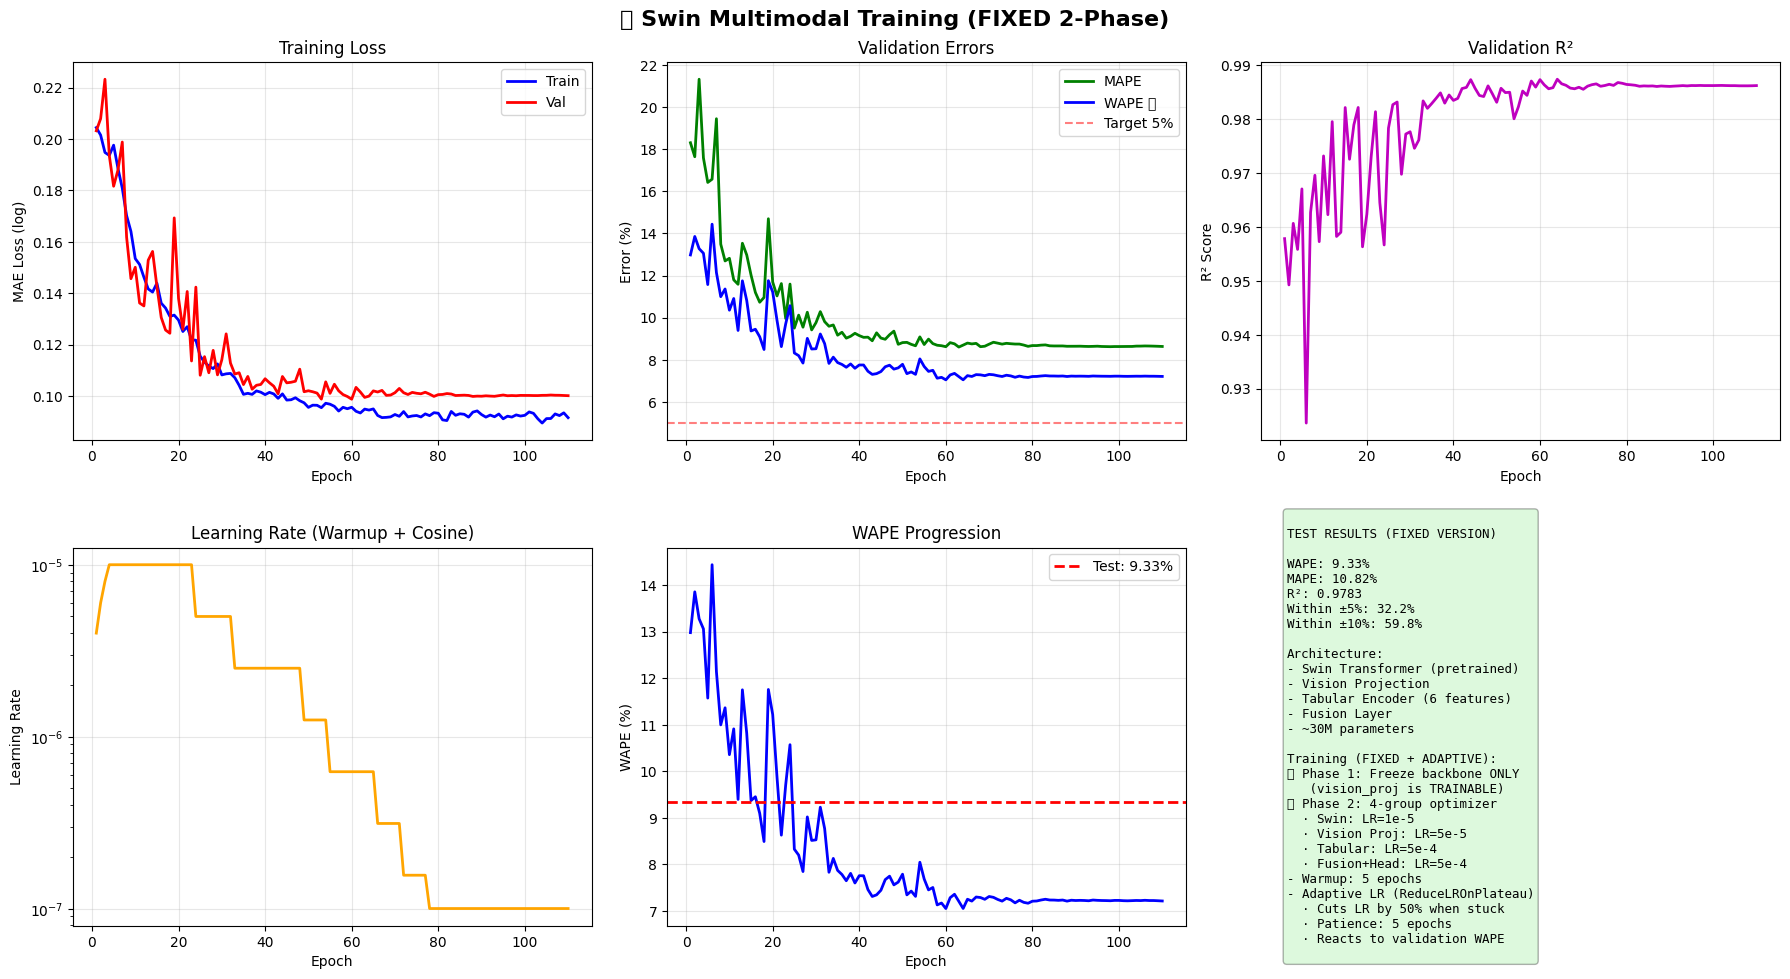


✅ TRAINING COMPLETE (FIXED + ADAPTIVE VERSION)!
🎯 Final Test WAPE: 9.33%
📊 Final Test MAPE: 10.82%
🏆 Model saved as: best_multimodal_model_fixed.pt

⚠️  Key Improvements:
   1. Vision_proj trained in Phase 1 (no ignored modality)
   2. Adaptive LR scheduler (reacts to plateaus automatically)
   3. Should see better convergence and lower WAPE!


In [13]:

if __name__ == "__main__":
    print("="*80)
    print("🚀 SWIN MULTIMODAL MODEL - FIXED + ADAPTIVE VERSION")
    print("="*80)
    print("Architecture: Swin + Tabular (Clean Features)")
    print("Features: Population, Area, Density, Seasonality, Time")
    print("NO demand, NO per_capita - LEGITIMATE PREDICTION!")
    print("\n⚠️  CRITICAL FIXES APPLIED:")
    print("   1. Phase 1 now trains vision_proj (prevents fusion ignoring vision)")
    print("   2. Adaptive LR scheduler (reacts to plateaus, not blind Cosine)")
    print("="*80 + "\n")

    # CUDA cleanup
    import gc
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print(f"✅ CUDA Device: {torch.cuda.get_device_name(0)}\n")

    # Paths
    csv_path = 'C:\\Users\\FA004\\Desktop\\satimg2\\data.csv'
    image_dir = 'C:\\Users\\FA004\\Desktop\\satimg2\\images'

    # Optional: Load vision-only checkpoint
    vision_checkpoint = 'best_swin_vision_only.pt'

    # Load data
    images, features, targets, years = load_multimodal_data(csv_path, image_dir)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"🎮 Device: {device}\n")

    # Train with fixed strategy
    model, feat_scaler, targ_scaler, test_metrics, test_loader = train_multimodal_model(
        images, features, targets, years, device,
        swin_variant='swin_tiny_patch4_window7_224',
        pretrained=True,
        vision_only_checkpoint=vision_checkpoint if os.path.exists(vision_checkpoint) else None
    )

    print("\n" + "="*80)
    print("✅ TRAINING COMPLETE (FIXED + ADAPTIVE VERSION)!")
    print("="*80)
    print(f"🎯 Final Test WAPE: {test_metrics['wape']:.2f}%")
    print(f"📊 Final Test MAPE: {test_metrics['mape']:.2f}%")
    print(f"🏆 Model saved as: best_multimodal_model_fixed.pt")
    print("\n⚠️  Key Improvements:")
    print("   1. Vision_proj trained in Phase 1 (no ignored modality)")
    print("   2. Adaptive LR scheduler (reacts to plateaus automatically)")
    print("   3. Should see better convergence and lower WAPE!")
    print("="*80)